In [60]:
from __future__ import print_function
import argparse
from math import log10

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from collections import defaultdict
import time

In [61]:
from super_resolution.model import Net, BayesianNet
from super_resolution.data import get_training_set, get_test_set

In [62]:
#upscale_factor = 3

class store:
    def __init__(self, up, b, t, n, l, th, se, ds):
        self.upscale_factor = up
        self.batchSize = b
        self.testBatchSize = t
        self.nEpochs = n
        self.lr = l
        self.threads = th
        self.seed = se
        self.dataset = ds
        
upscale_factor = 3
batchSize = 4
testBatchSize = 100

#nEpochs = 2
nEpochs = 1
lr = .001
dataset = "BSD300"
threads = 3
seed = 123
        
opt = store(upscale_factor, batchSize, testBatchSize, nEpochs, lr, threads, seed, dataset)


In [63]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
torch.manual_seed(seed)

In [64]:
print('===> Loading datasets')
train_set = get_training_set(opt.upscale_factor, dataset=opt.dataset)
test_set = get_test_set(opt.upscale_factor, dataset=opt.dataset)
train_set = get_training_set(opt.upscale_factor, dataset=opt.dataset)

training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, batch_size=opt.batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize, shuffle=False)

===> Loading datasets


In [65]:
print('===> Building model')
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}

===> Building model


In [66]:

import metrics
class ELBO(nn.Module):
    def __init__(self, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size

    def forward(self, input, target, kl, beta):
        assert not target.requires_grad
        log_likelihood = 0.5 * torch.sum((target - input) ** 2)
        return log_likelihood * self.train_size + beta * kl

def train(model, optimizer, criterion, epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        torch.cuda.empty_cache()
        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        kl = 0
        if model.__class__.__name__ == 'BayesianNet':
            output, kl = model(input)
        else:
            output = model(input)
        if criterion.__class__.__name__ == 'ELBO':
            beta = metrics.get_beta(iteration-1, len(training_data_loader), beta_type=0.1, epoch=epoch, num_epochs=opt.nEpochs)
            loss = criterion(output, target, kl, beta)
        else:
            loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        # print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch, epoch_loss / len(training_data_loader)


def test(model, criterion):
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device), batch[1].to(device)
            if model.__class__.__name__ == 'BayesianNet':
                prediction, kl = model(input)
            else:
                prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
    return avg_psnr / len(testing_data_loader)


def checkpoint(model, epoch, upscale_factor):
    ckpt_dir = f'./super_resolution/models/{model.__class__.__name__}/{opt.dataset}'
    model_out_path = f"./super_resolution/models/{model.__class__.__name__}/{opt.dataset}/epoch_{epoch}_upscale_factor_{upscale_factor}_device_{str(device).split(':')[0]}.pth"

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)
    
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [67]:
model = BayesianNet(1, upscale_factor, priors, layer_type='lrt')

In [68]:
type(model.conv2)

layers.BBB_LRT.BBBConv.BBBConv2d

In [69]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


for upscale_factor in [opt.upscale_factor]:
    models = {"Bayesian CNN": BayesianNet(1, upscale_factor, priors, layer_type='lrt', activation_type='relu').to(device),
        "Classical CNN": Net(upscale_factor=upscale_factor).to(device)
    }
    epochs = defaultdict(list)
    epoch_losses = defaultdict(list)
    avg_psnrs = defaultdict(list)
    times = defaultdict(list)
    
    file_name_epoch_loss = f"upscale_{upscale_factor}__total_epocs_{opt.nEpochs}_epoch_loss"
    file_name_ave_psnrs = f"upscale_{upscale_factor}__total_epocs_{opt.nEpochs}_avg_psnrs"
    file_name_times = f"upscale_{upscale_factor}__total_epocs_{opt.nEpochs}_times"
    
    for model_name in models.keys():
        model = models[model_name]

        test_criterion = nn.MSELoss()
        # criterion = ELBO(len(training_data_loader))
        criterion = nn.MSELoss()

        optimizer = optim.Adam(model.parameters(), lr=opt.lr)
        
        prev_time = time.time()
        for epoch in range(1, opt.nEpochs + 1):
            # TODO: for stats see train.py
            epoch, epoch_loss = train(model, optimizer, criterion, epoch)
            avg_psnr = test(model, test_criterion)
            checkpoint(model, epoch, upscale_factor)
            
            epochs[model_name].append(epoch)
            epoch_losses[model_name].append(epoch_loss)
            avg_psnrs[model_name].append(avg_psnr)
            times[model_name].append(time.time() - prev_time)
            prev_time = time.time()
            
    result_dir = f'./stats/{opt.dataset}'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir, exist_ok=True)
        
    epoch_losses_df = pd.DataFrame.from_dict(epoch_losses)
    epoch_losses_df["epoch"] = epoch_losses_df.index + 1
    avg_psnrs_df = pd.DataFrame.from_dict(avg_psnrs)
    avg_psnrs_df["epoch"] = epoch_losses_df.index + 1
    times_df = pd.DataFrame.from_dict(times)
    times["epoch"] = epoch_losses_df.index + 1
    
    epoch_losses_df.to_csv(f"./stats/{opt.dataset}/{file_name_epoch_loss}.csv")
    avg_psnrs_df.to_csv(f"./stats/{opt.dataset}/{file_name_ave_psnrs}.csv")
    times_df.to_csv(f"./stats/{opt.dataset}/{file_name_times}.csv")

===> Epoch 1 Complete: Avg. Loss: 0.0565
===> Avg. PSNR: 17.9179 dB
Checkpoint saved to ./super_resolution/models/BayesianNet/bsd300/epoch_1_upscale_factor_3_device_cuda.pth
===> Epoch 2 Complete: Avg. Loss: 0.0115
===> Avg. PSNR: 20.1243 dB
Checkpoint saved to ./super_resolution/models/BayesianNet/bsd300/epoch_2_upscale_factor_3_device_cuda.pth
===> Epoch 3 Complete: Avg. Loss: 0.0081
===> Avg. PSNR: 21.0936 dB
Checkpoint saved to ./super_resolution/models/BayesianNet/bsd300/epoch_3_upscale_factor_3_device_cuda.pth
===> Epoch 4 Complete: Avg. Loss: 0.0068
===> Avg. PSNR: 21.7038 dB
Checkpoint saved to ./super_resolution/models/BayesianNet/bsd300/epoch_4_upscale_factor_3_device_cuda.pth
===> Epoch 5 Complete: Avg. Loss: 0.0060
===> Avg. PSNR: 22.1511 dB
Checkpoint saved to ./super_resolution/models/BayesianNet/bsd300/epoch_5_upscale_factor_3_device_cuda.pth
===> Epoch 6 Complete: Avg. Loss: 0.0054
===> Avg. PSNR: 22.5095 dB
Checkpoint saved to ./super_resolution/models/BayesianNet/bsd3

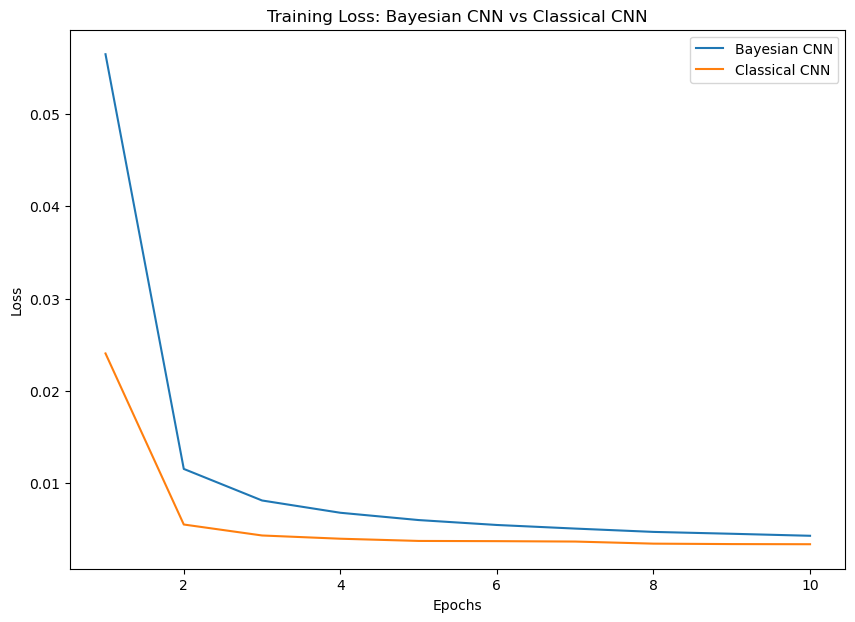

In [70]:
# loss plots
plt.figure(figsize=(10, 7))
plt.title(f"Training Loss: Bayesian CNN vs Classical CNN")

for model_name in epochs:
    plt.plot(epochs[model_name], epoch_losses[model_name], label=model_name)
# plt.plot(val_loss, color='red', label='validataion loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig(f'./graphs/loss_model_{model.__class__.__name__}_epochs_{opt.nEpochs}_upscale_factor_{upscale_factor}.png')

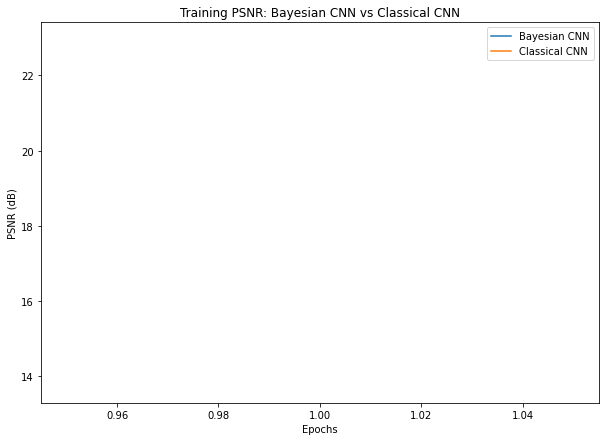

In [71]:
# loss plots
plt.figure(figsize=(10, 7))
plt.title(f"Training PSNR: Bayesian CNN vs Classical CNN")

for model_name in epochs:
    plt.plot(epochs[model_name], avg_psnrs[model_name], label=model_name)

# plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()    

